In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import math

In [3]:
def fraunhofer(src, z):
    if z > 0:
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(src)))
    else:
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(src)))

In [4]:
def angular(src, dx, wavelength, z):

    ysize, xsize = src.shape
    
    src_expanded = np.zeros((2 * xsize, 2 * ysize), dtype=np.complex)
    src_expanded[(xsize//2):(3*xsize//2), (ysize//2):(3*ysize//2)] = src

    #showImg(np.abs(src_expanded))

    u = np.fft.fftfreq(2 * xsize, dx / 2)
    v = np.fft.fftfreq(2 * ysize, dx / 2)
    u, v = np.meshgrid(u, v)
  
    # antialias filter
    du = 1.0 / (dx * xsize)
    dv = 1.0 / (dx * ysize)
    u_limit = 1.0 / math.sqrt(1 + (2 * du * z)**2) / wavelength
    v_limit = 1.0 / math.sqrt(1 + (2 * dv * z)**2) / wavelength
    bandlimit = (np.abs(u) < u_limit) & (np.abs(v) < v_limit)
    
    uv_sq = u ** 2 + v ** 2
    not_evanescent = (1.0 / wavelength**2 > uv_sq)

    mask = not_evanescent & bandlimit
    
    g = np.zeros((2 * xsize, 2 * ysize), dtype = np.complex)
    g[mask] = np.exp(1.0j * np.sqrt(1.0 / wavelength**2 - uv_sq[mask]) * z)
    
    return np.fft.ifft2(g * np.fft.fft2(src_expanded))[(xsize//2):(3*xsize//2), (ysize//2):(3*ysize//2)]

In [5]:
wavelength = 632.8e-9
k = 2.0 * math.pi / wavelength

a = 1000.05624604543e-3
b = 10.6068254211646e-3

f1 = 0.0
f2 = f1 + 2.0 * math.hypot(a, b)

# parabola part
p = 0.0562460454334836e-3

# whole mirror
WD = 1902.50110774383e-3
ML = 200.0e-3

# 接合点を求める2次方程式
param1 = a**-2
param2 = -(f1 + f2) / a**2 + 4 * p / b**2
param3 = (f1 + f2)**2 / (4 * a**2) - 4 * p * (p + f2) / b**2 - 1.0
seam = (-param2 - math.sqrt(param2**2 - 4.0 * param1 * param3)) / (2.0 * param1)

# xy plane params
entrance_radius = math.sqrt(-4 * p * (f1 - WD - ML - p - f2))
seam_radius = math.sqrt(-4 * p * (seam - p - f2))
exit_radius = b * math.sqrt((f1 - WD - (f1 + f2) / 2)**2 / a**2 - 1.0)
ring_radius = seam_radius * WD / (f1 - seam)

ring_thickness = exit_radius - ring_radius

# equipment params
ccd_num = 4096

def print_param(x):
    print(x, ':', eval(x))

print_param('exit_radius')
print_param('ring_radius')
print_param('seam_radius')
print_param('entrance_radius')
print_param('ring_thickness')
print(30.0 - (exit_radius - ring_radius))

exit_radius : 0.028900860897701938
ring_radius : 0.028537516616092457
seam_radius : 0.030000000000022727
entrance_radius : 0.030381921069158307
ring_thickness : 0.00036334428160948035
29.99963665571839


In [6]:
# Transverse Translation

binning = 2
ccd_pitch = 9.0e-6 * binning
N = round(ccd_num / binning)
detector_length = ccd_pitch * N

# simulation params
CD = WD
exit_pixel_size = wavelength * CD / detector_length
exit_length = N * exit_pixel_size

print_param('CD')
print_param('exit_pixel_size')
print_param('exit_length')

CD : 1.90250110774383
exit_pixel_size : 3.265795087294639e-05
exit_length : 0.06688348338779421


In [7]:
pinhole_rev_radius = 57.26e-3 / 2
pinhole_radius = 2.25e-3 / 2

step_deg = 0.004 * 337
step_rad = step_deg / 180 * math.pi
#scan_num = 268
scan_num = 134

pinhole_margin = 0.0
pinhole_thickness = 0.0

print_param('pinhole_rev_radius')
print_param('pinhole_radius')

pinhole_rev_radius : 0.02863
pinhole_radius : 0.001125


In [8]:
def isInPinhole(x, y, theta):
    return np.hypot(x - pinhole_rev_radius * math.cos(theta), y - pinhole_rev_radius * math.sin(theta)) < pinhole_radius

def getPinholeMask(rot_theta):
    x = np.linspace(-0.5 * exit_length, 0.5 * exit_length, N)
    y = x.copy()
    x, y = np.meshgrid(x, y)

    hole0 = isInPinhole(x, y, rot_theta)
    hole1 = isInPinhole(x, y, rot_theta + 0.25 * math.pi)
    hole2 = isInPinhole(x, y, rot_theta + math.pi)

    return hole0 | hole1 | hole2

In [9]:
def showImg(np_array):
    plt.imshow(np_array, origin='lower')

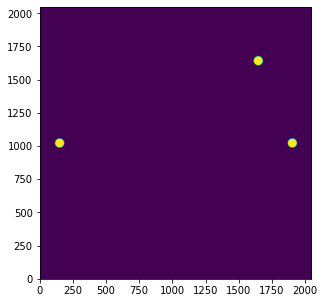

In [10]:
plt.figure(figsize=(5, 5))
showImg(getPinholeMask(0.0))

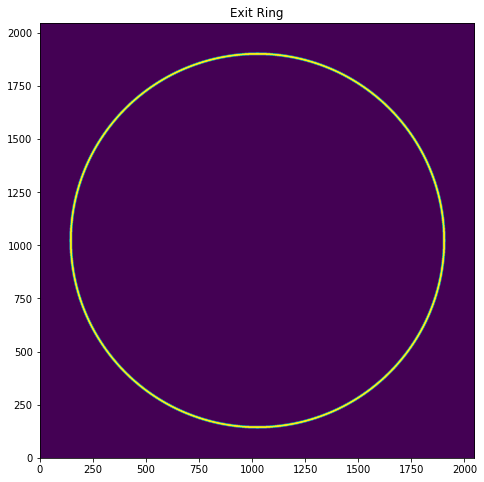

In [11]:
x = np.linspace(-0.5 * exit_length, 0.5 * exit_length, N)
y = x.copy()
x, y = np.meshgrid(x, y)

r = np.hypot(x, y)
theta = np.arctan2(y, x)

ring = np.zeros((N, N), dtype=np.complex)
on_ring = (ring_radius <= r) & (r <= exit_radius)
ring[on_ring] = 1.0

plt.figure(figsize=(8, 8))
plt.title("Exit Ring")
showImg(np.abs(ring))

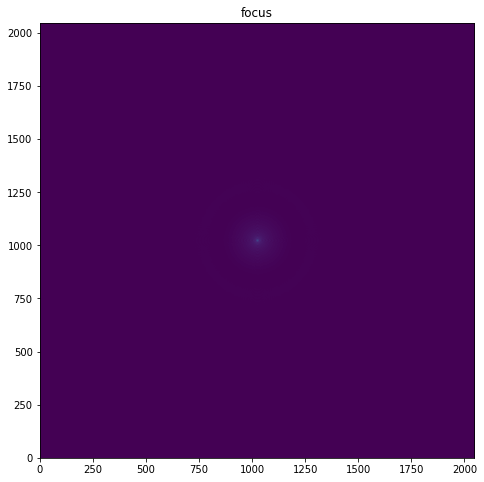

In [12]:
whole_focus = fraunhofer(ring, WD)

plt.figure(figsize=(8, 8))
plt.title("focus")

showImg(np.abs(whole_focus))

In [13]:
pinhole_out = ring * getPinholeMask(0.0)
pinhole_focus = fraunhofer(pinhole_out, CD)

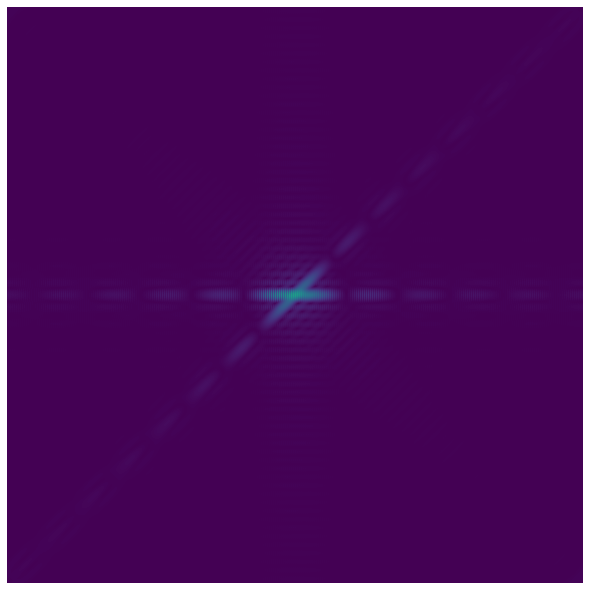

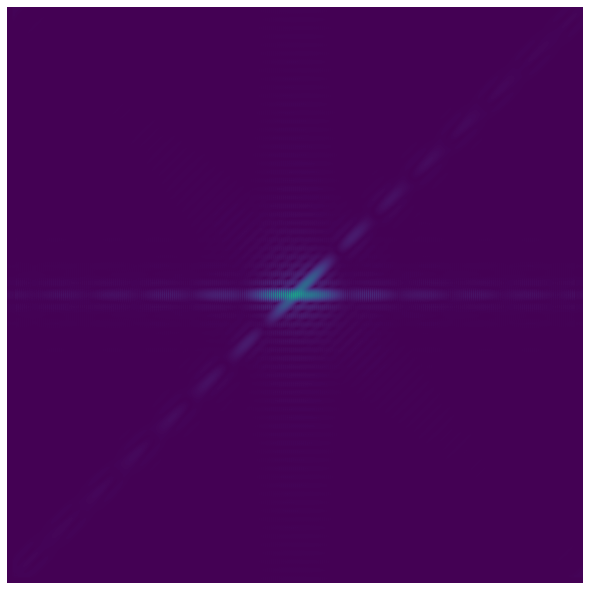

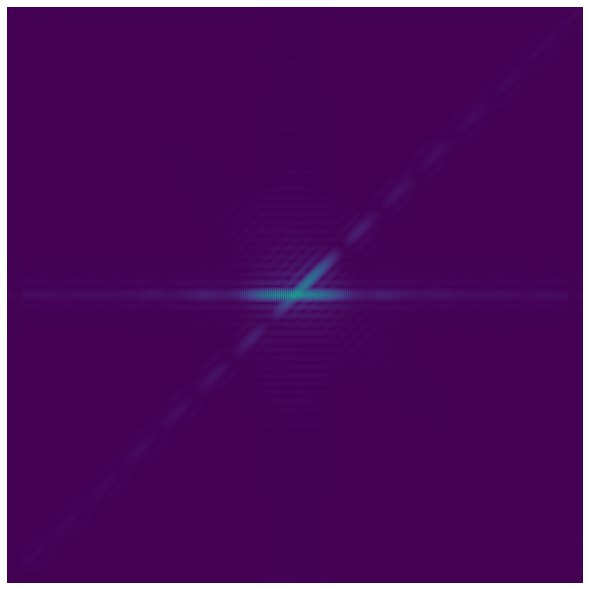

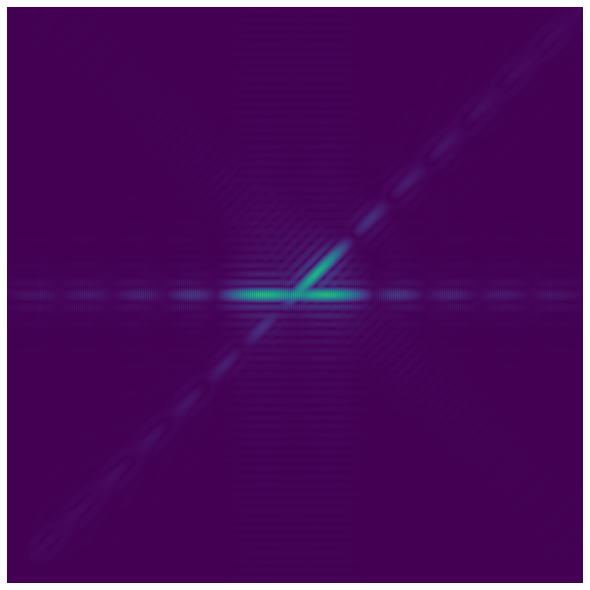

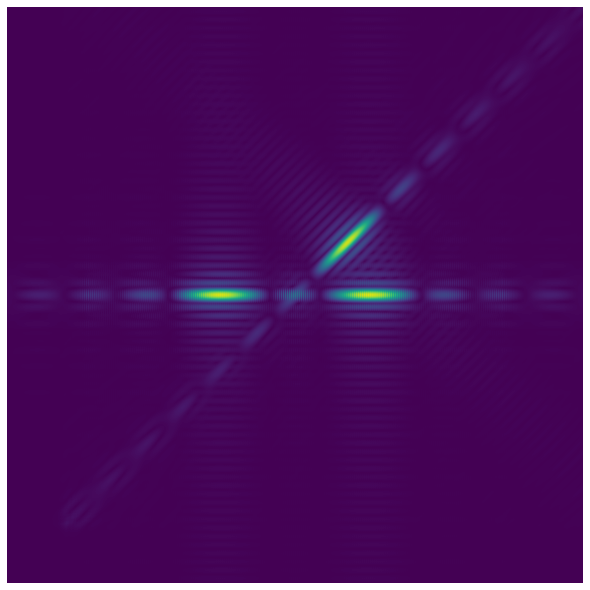

In [15]:
for defocus_mm in [0, 50, 100, 200, 500]:

    defocus = defocus_mm * 1.0e-3
    pinhole_defocus = angular(pinhole_focus, ccd_pitch, wavelength, -defocus)

    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    showImg(np.abs(pinhole_defocus_before))
    fig.savefig('../../thesis/chap3/figure/transverse_onway/' + str(defocus_mm) + 'mm_before.png')

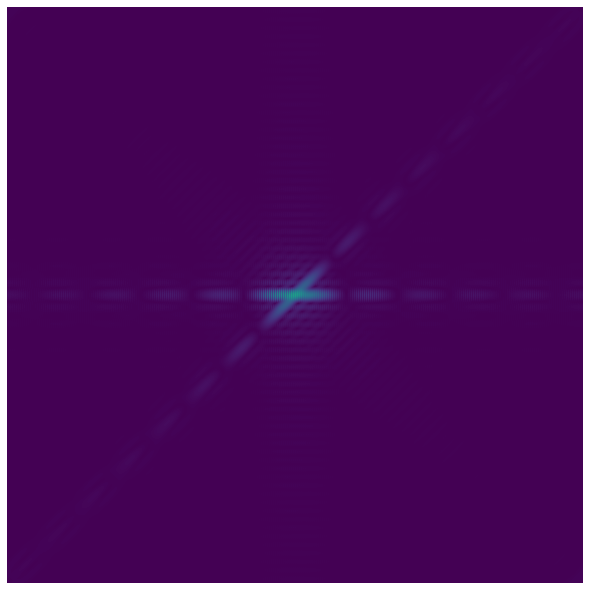

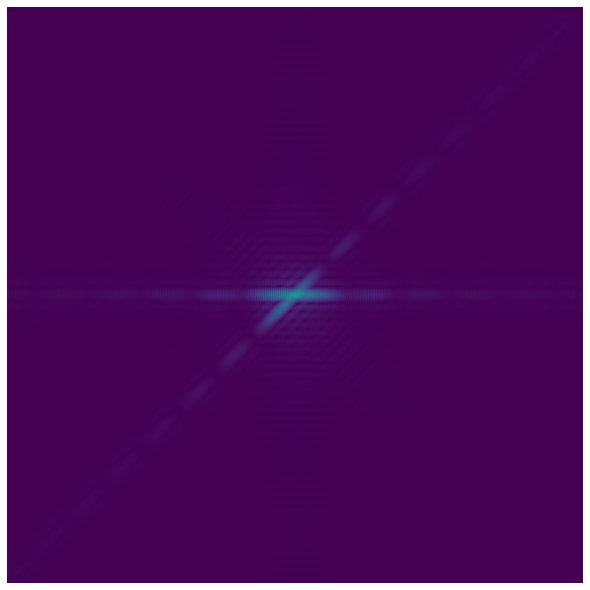

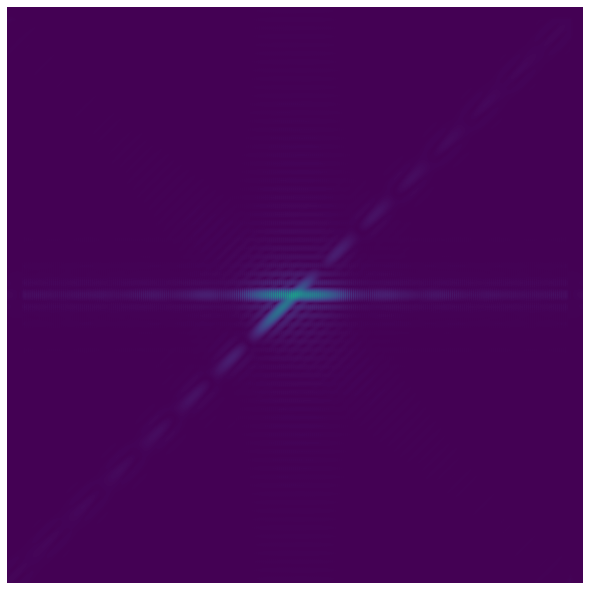

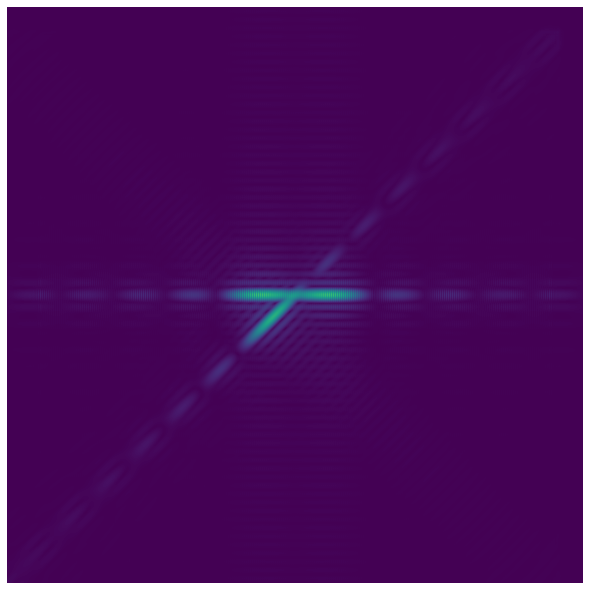

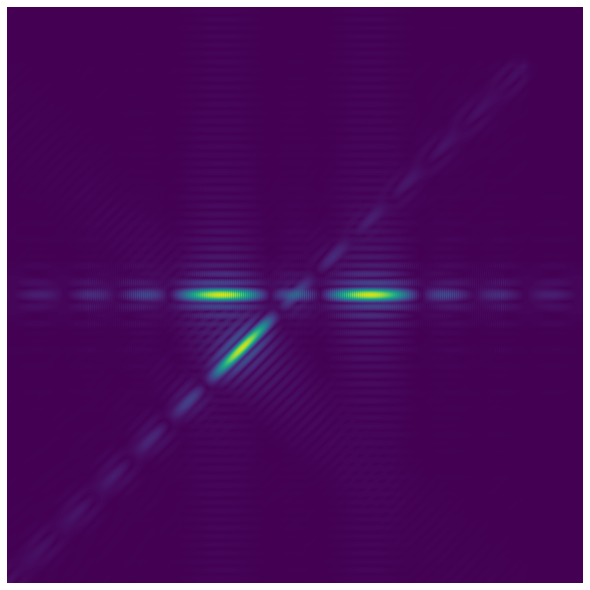

In [16]:
for defocus_mm in [0, 50, 100, 200, 500]:

    defocus = defocus_mm * 1.0e-3
    pinhole_defocus = angular(pinhole_focus, ccd_pitch, wavelength, defocus)

    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    showImg(np.abs(pinhole_defocus))
    fig.savefig('../../thesis/chap3/figure/transverse_onway/' + str(defocus_mm) + 'mm_after.png')